Привет, меня зовут Артем. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.metrics import make_scorer, mean_squared_error

pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [16]:
def read_csv(res1, res2):
    #читаем из двух источников, дату - в индекс, сортируем на всякий случай по индексу, и ресэмпл по часу
    try:
        df = pd.read_csv(res1, parse_dates=['datetime'], index_col=['datetime'])
    except:
        df = pd.read_csv(res2, parse_dates=['datetime'], index_col=['datetime'])

    df.sort_index(inplace=True)
    df = df.resample('1H').sum()
    
    return df


def rmse(y_test, y_pred):
    return mean_squared_error(y_test, y_pred)**0.5


def make_features(df, max_lag, rolling_size, ewm_size):
    # генерим признаки
    
    data = df.copy()
    # календарные
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # сдвиги и разность
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # скользящие
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    data['exp_mean'] = data['num_orders'].shift().ewm(min_periods=ewm_size, span=2).mean()

    data.dropna(inplace=True)
    return data

<div class="alert alert-block alert-info">

<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемый внутри функции. В этот момент копирование датасета станет обязательным.
</div>

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Учёл
</div>

In [3]:
df = read_csv('taxi.csv', '/datasets/taxi.csv')
display(df.head(3))
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
# проверим на монотооность
df.index.is_monotonic

True

**Предварительные выводы**  
- Загрузили данные. в Данных только столбец - кол-во заказов. 
- Сделали ресемпл по 1 часу
- проверили на монотонность, все хорошо.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

In [5]:
print(f'Итак, мы будем работать с временным промежутоком с {df.index[0]} до {df.index[-1]}')

Итак, мы будем работать с временным промежутоком с 2018-03-01 00:00:00 до 2018-08-31 23:00:00


У нас почасовки заказов такси за полгода

<AxesSubplot:xlabel='datetime'>

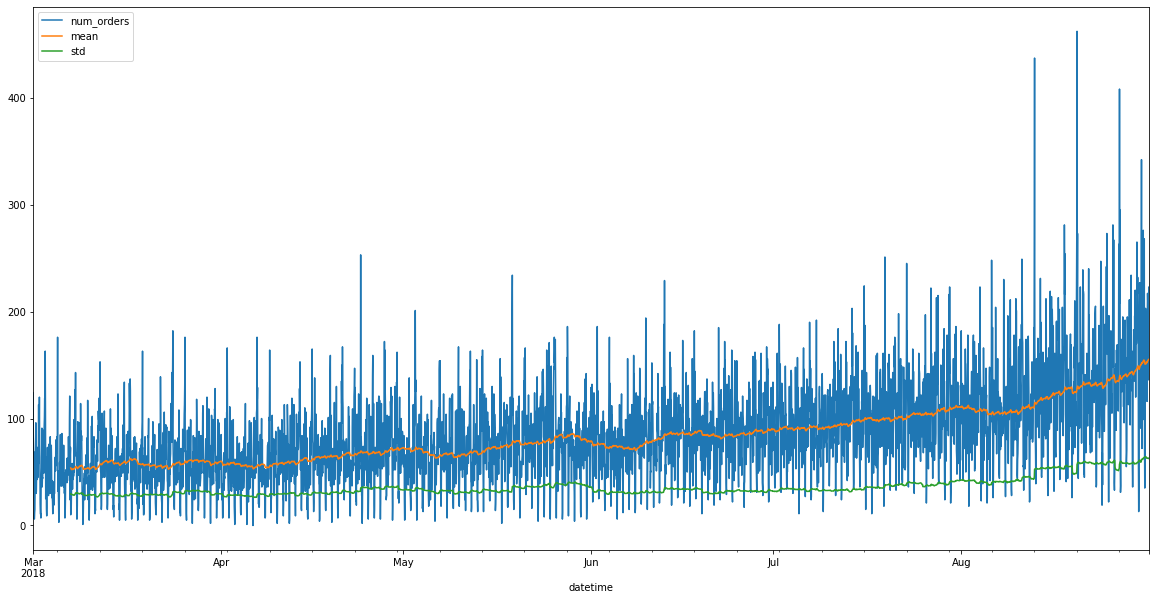

In [6]:
#посмотрим на графики
# почасовок много посмотрим на дневные заказы для наглядности
df_rolling = df.copy()
df_rolling['mean'] = df_rolling['num_orders'].rolling(150).mean()
df_rolling['std'] = df_rolling['num_orders'].rolling(150).std()
df_rolling.plot(figsize=(20,10)) 

временной ряд не стационарный среднее растет (стандартное отклонение тоже к концу периода чуть увеличивается)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Во всех графиках в проекте нужно подписать оси и названия, чтобы было понятно, что на нем визуализировано.
</div>

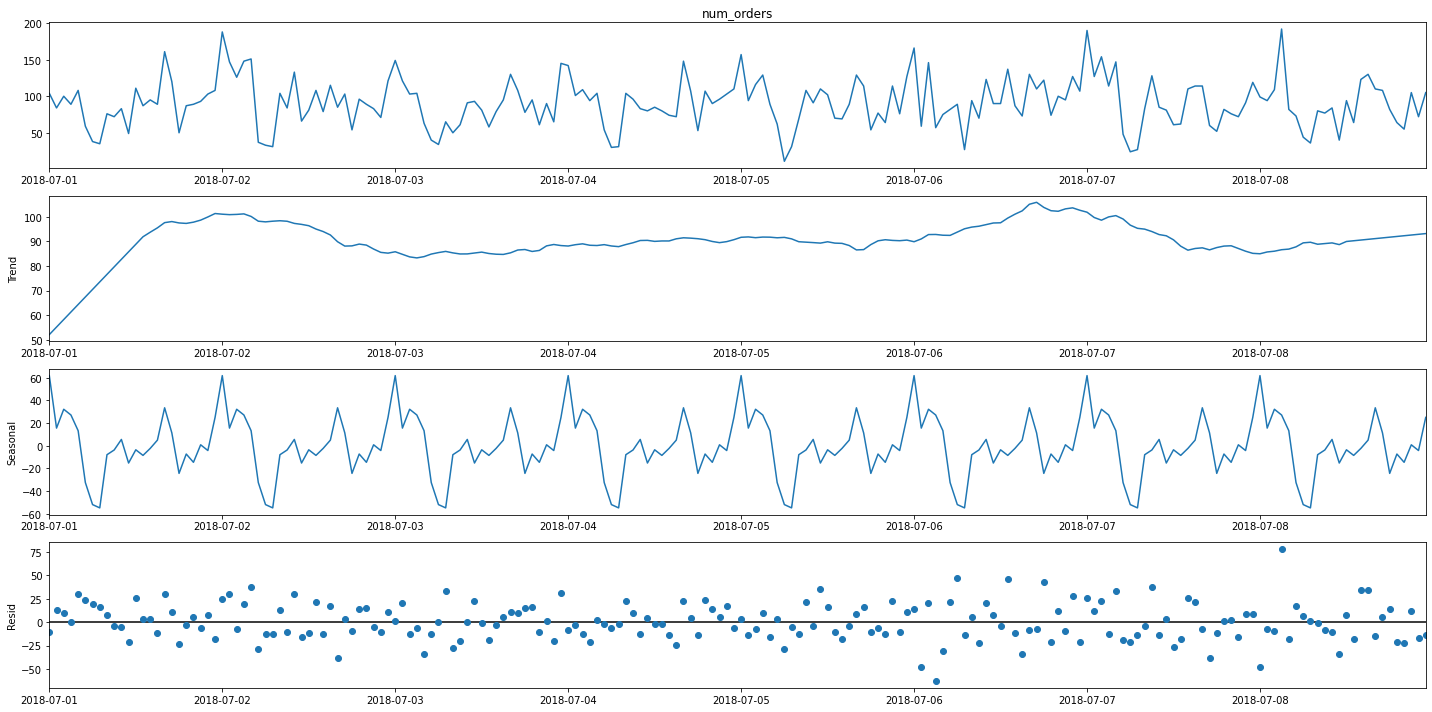

In [7]:
# если разложить на тренд/сезонность весь интервал - то будет ненаглядно
# посмотрим на одну неделю июля
decomposition = seasonal_decompose(df_rolling['num_orders']['2018-07-01':'2018-07-08'], model='additive', extrapolate_trend = 1) 
plt.rcParams["figure.figsize"] = (20, 10)
decomposition.plot()
plt.show()

Видим, что сезонность просматривается следующая: Где то к полуночи пик заказов такси, потом под утро спадает. в локальный минимум, затем растет примерно до конца рабочего рабочего дня, затем спад и рост до пика к полуночи

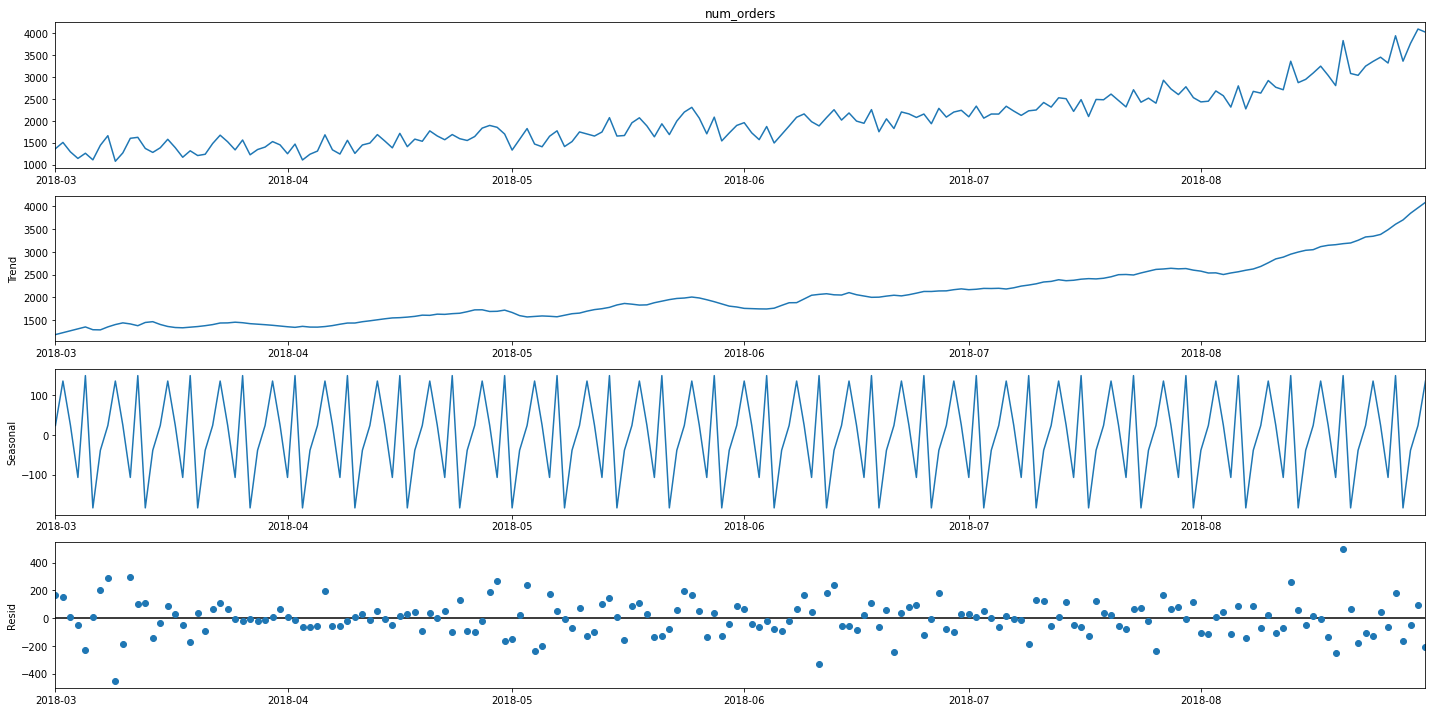

In [8]:
# интереснее посмотреть на тренд/сезонность не почасовок а по дням
decomposition = seasonal_decompose(df_rolling['num_orders'].resample('1D').sum(), model='additive', extrapolate_trend = 1) 
decomposition.plot()
plt.show()

Видим, что хорошо выделяется равномерный тренд с ростом заказов в день примерно от 1 тысячи до 4 за полгода

**Предварительные выводы**  
Посмотрели временной ряд:
- ряд является не стационарным, так как растет среднее со временем примерно с 1 тыс заказов в день до 4
- Посмотрели сезонность почасовок - хорошо виден пик на полуночи и спад в утренние часы

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

## Обучение

рассмотрим три модели прогнозирования LinearRegression, RandomForestRegressor и CatBoostRegressor

In [9]:
# Модели ml. 

# сгенерим признаки
new_df = make_features(df, 10, 15, 15)

# понимаем, что для линейной регрессии все календарные признаки это будут категориальные и их надо будет заэнкодить
cat_features = ['year', 'month', 'day', 'dayofweek', 'hour']
num_features = new_df.columns[6:].to_list()

X_train, X_test, y_train, y_test = train_test_split(new_df.drop('num_orders', axis=1), new_df['num_orders'], 
                                                    shuffle=False, 
                                                    random_state=666,
                                                    test_size=0.1)


# проверка
print('Размер признаков на обучающей выборке', X_train.shape)
print('Размер целевой переменной на обучении', y_train.shape)
print('Размер призаков на тестовой выборке', X_test.shape)
print('Размер целевой переменной на тесте', y_test.shape)
print('-'*50)
print(f'Начало трейна {X_train.index[0]}, конец трейна {X_train.index[-1]}')
print(f'Начало теста {X_test.index[0]}, конец теста {X_test.index[-1]}')

Размер признаков на обучающей выборке (3960, 17)
Размер целевой переменной на обучении (3960,)
Размер призаков на тестовой выборке (441, 17)
Размер целевой переменной на тесте (441,)
--------------------------------------------------
Начало трейна 2018-03-01 15:00:00, конец трейна 2018-08-13 14:00:00
Начало теста 2018-08-13 15:00:00, конец теста 2018-08-31 23:00:00


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

In [10]:
# LinearRegression

# Препроцесиснг для линейных моделей
numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("labelencoder", OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, cat_features),
        ("numerical", numeric_preprocessor, num_features),
    ])

In [11]:
# Пайплайн

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regressor", LinearRegression())]
)

param_grid = {}

grid_search_lr = RandomizedSearchCV(pipe,
                           param_grid,
                           scoring = make_scorer(rmse, greater_is_better=False),
                           n_jobs=-1, 
                           cv=7)

grid_search_lr.fit(X_train, y_train)
print('RMSE линейной регрессии: ', -grid_search_lr.best_score_)

RMSE линейной регрессии:  24.69191400051404


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Перейдя к разности ты изменил задачу, а значит теперь у тебя RMSE – задачи предсказания разности, а нужно измерить метрику исходной задачи. Нужно сделать обратное преобразование или вообще не переходить к разности.
</div>

In [ ]:
# Лес

pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('regressor', RandomForestRegressor())
                    ])

param_grid = {'regressor__n_estimators':[100, 200],
              'regressor__max_depth':[10,50],
              'regressor__min_samples_split':[x for x in range(4,7,2)],
              'regressor__min_samples_leaf':[x for x in range(4,7,2)],
              }

grid_search_rfr  = RandomizedSearchCV(pipe,
                                param_grid, 
                                scoring = make_scorer(rmse, greater_is_better=False), 
                                n_jobs=-1, 
                                cv=7
                                )


grid_search_rfr.fit(X_train, y_train)

print('RMSE случайного леса: ', -grid_search_rfr.best_score_)

In [ ]:
# CatBoost


pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('regressor', CatBoostRegressor())
                    ])

param_grid = {'regressor__depth': [x for x in range(5,11,5)],
              'regressor__learning_rate': [0.1, 0.5],
              'regressor__iterations': [x for x in range(50,91,40)]
              }


grid_search_cb  = RandomizedSearchCV(pipe,
                                        param_grid, 
                                        scoring = make_scorer(rmse, greater_is_better=False), 
                                        n_jobs=-1, 
                                        cv=7
                                        )


grid_search_cb.fit(X_train, y_train)

print('RMSE CatBoost-а: ', -grid_search_cb.best_score_)

**Предварительные выводы**
Построили три модели ml для предсказания кол-ва заказов. В принципе все модели отрабатывают неплохо с небольшой разницей
LinearRegression RMSE = 24.64  
Случайный лес RMSE = 23.47
CatBoost RMSE = 23.55
Лучшая модель - случайный лес

## Тестирование

In [ ]:
# проверим лучшую модель на тесте

y_pred = grid_search_rfr.predict(X_test)

print("RMSE на тестовой выборке для случайного леса:", rmse(y_pred, y_test))

<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

In [ ]:
# В качестве dummy прогноза кол-ва заказов используем sesonal_decompose. 
# Примем, что тренд это f(x) = kx + b, сезонность у нас повторяется по часам. Соответственно прогноз это сумма функций тренда и сезонности.

train, test = train_test_split(df.iloc[:,0], shuffle=False, test_size=0.1, random_state=666)

decomposition = seasonal_decompose(train, model='additive', extrapolate_trend = 1)

# для функции тренда (берем для тренда последние 1000 значений и среднюю разницу между ними)
diff_trend_mean = decomposition.trend.diff().mean()
# diff_trend_mean

# находим сезонное значение для каждого часа
season_hour_table = pd.DataFrame(decomposition.seasonal)
season_hour_table['hour'] = season_hour_table.index.hour
season_hour_table = season_hour_table.groupby('hour')['seasonal'].median()

pred_sd = test*0
previos_trend = decomposition.trend[-1]
for i in range(test.shape[0]):
    hour_i = pred_sd.index.hour[i]
    seasonal_i = season_hour_table[hour_i]

    pred_sd.iloc[i] = seasonal_i + previos_trend + diff_trend_mean
    previos_trend += diff_trend_mean

rmse(pred_sd, test)

Вобщем то без моделей ml, используя тренд и сезонность получили требуемую точность rmse < 48.  
Результат на тесте у случайного леса немного лучше - 43.65


<div class="alert alert-block alert-info">
<b>Совет: </b> У тебя тут допущена утечка.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
Можно подробнее? не вижу.  
по шагам:  
- сделал декомпозицию на трэйне  
- взял среднее смещение на тренде  
- взял значение по каждому часу в сизонал  
- посчитал x_i = последнее значение тренда из трейна + среднее смещение тренда + сезонная составляющая (обновил   последнее значение тренда), перешел x_i+1 , повторил пока не заполнил предикт
</div>

**Выводы**
1. Загрузили данные.
-  в Данных только столбец - кол-во заказов. 
- Сделали ресемпл по 1 часу
- проверили на монотонность, все хорошо.
2. Проанализировали временной ряд:
- ряд является не стационарным, так как растет среднее со временем примерно с 1 тыс заказов в день до 4
- Посмотрели сезонность почасовок - хорошо виден пик на полуночи и спад в утренние часы
3. Построили три модели ml для предсказания кол-ва заказов. В принципе все модели отрабатывают неплохо с небольшой разницей
- LinearRegression RMSE = 24.64  
- Случайный лес RMSE = 23.47
- CatBoost RMSE = 23.55
Лучшая модель - случайный лес
4. Провели предикт на тестовой выборке. RMSE на уровне 43.65, что удовлетворяет условию поставленной задачи.

Что хочется отметить: Построение прогноза временного ряда без применения моделей ml может быть использована, если нет основной цели получить наилучшее RMSE. То есть резултат модели прогноза на базе seasonal_decompose удовлетворяет условиям 46.54, что меньше 48. При этом модель случайного леса не намного лучше - 43.65.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48